In [103]:
#select geno
import h5py
from Bio import AlignIO
import pickle
from matplotlib import pyplot as plt
import numpy as np
#run annot
from scipy.sparse import lil_matrix

import random


In [ ]:
#save each cl
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')
crange = [ c.get_hex_l() for c in red.range_to(blue, 100) ]
print(crange)

with open( 'crange.pkl' , 'wb') as crangeout:
    crangeout.write(pickle.dumps(crange))

In [94]:
treefile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln.treefile'
alnfile = '/home/cactuskid13/covid/coevDataCOVID/02_07_2020_GISAID_IQTree_NS_mask/gisaid_hcov-2020_07_02.QC.NSoutlier.filter.NSmask.aln'
alnh5 = alnfile+'.h5'

In [95]:
#choose sequence
with h5py.File(alnh5, 'r') as hf:
    align_array = hf['MSA2array'][:]
print(align_array.shape)
msa = AlignIO.read(alnfile , format = 'fasta')

def clipID(ID):
    return ''.join( [ s +'|' for s in str(ID).split('|')[:-1] ])[:-1].replace('_',' ') 
IDs = {i:rec.id for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
print( [(t,IDindex[t]) for t in list(IDindex.keys())[0:10]] )

(35244, 29903)
[('hCoV-19/Wuhan-Hu-1/2019|EPI_ISL_402125', 0), ('hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20', 1), ('hCoV-19/Scotland/EDB410/2020|EPI_ISL_426002|2020-03-30', 2), ('hCoV-19/Scotland/EDB413/2020|EPI_ISL_426004|2020-03-29', 3), ('hCoV-19/Scotland/EDB421/2020|EPI_ISL_426006|2020-03-30', 4), ('hCoV-19/Wuhan/Hu-1/2019|EPI_ISL_402125|2019-12-31', 5), ('hCoV-19/Sichuan/SC-NJ-089/2020|EPI_ISL_451338|2020-02-05', 6), ('hCoV-19/Sichuan/SC-WCH3-259/2020|EPI_ISL_451385|2020-02-03', 7), ('hCoV-19/Sichuan/SC-WCH4-285/2020|EPI_ISL_451387|2020-01-27', 8), ('hCoV-19/Sichuan/SC-WCH4-286/2020|EPI_ISL_451388|2020-02-10', 9)]


In [118]:
seq = 'hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20'
print('seq chosen: ' , seq)
#index all non gap cols
aln_row = align_array[IDindex[seq],:]
nongap_cols = [ i for i,c in enumerate(list(aln_row)) if c != b'-' ]


seq chosen:  hCoV-19/Iceland/447/2020|EPI_ISL_424471|2020-03-20


In [97]:
with open( alnfile+ 'blurmatr3.pkl' , 'rb') as matin:
    coevmat = pickle.loads(matin.read())


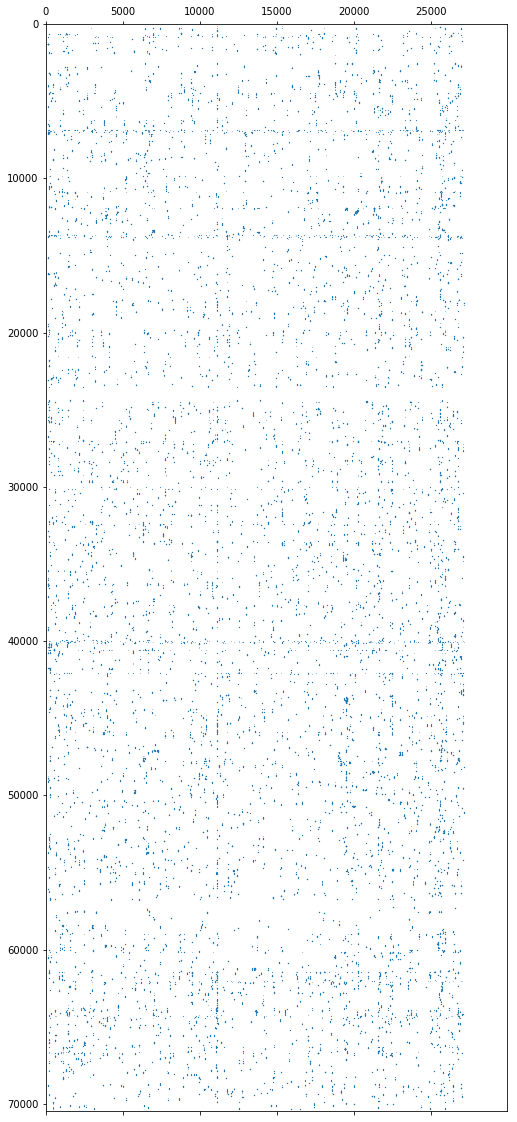

In [6]:
submat_coev = coevmat[: , nongap_cols ]
submat_aln = align_array[:,nongap_cols ]
plt.figure( figsize=(30,200))
plt.spy(submat_coev ,  markersize = 1)


In [7]:
qseq = b''.join(aln_row[nongap_cols])
qfile = 'covid_geno.fasta'
with open(qfile , 'w') as geno_out:
    geno_out.write((b'>testgeno\n'+qseq).decode())
    #print( (b'>testgeno\n'+qseq).decode())


In [8]:
import subprocess
import shlex
import pandas as pd 
#collapse codons
#use tblastn to map to prot

def runblastx( qseq , outannot = 'outannot.txt' , outfmt = None ):
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = 'blastx -query '+ qfile + ' -db covid_prots -outfmt' + outfmt + ' -out ' + outannot  
    p = subprocess.run( shlex.split(args) )
    return p , outannot
out = 'outannot.txt'
p,annot = runblastx(qfile  )

annotation = pd.read_csv( out , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]
print(annotation)
print(len(annotation), ' orfs detected')

#recluster codons
#load blast results into df

 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0   testgeno  YP_009724389.1  29903  7096     266  13468       2   
1   testgeno  YP_009724389.1  29903  7096   13462  21552       1   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
7   testgeno  YP_009742610.1  29903  1945    2720   8554       2   
11  testgeno  YP_009724390.1  29903  1273   21596  25381       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
14  testgeno  YP_009742609.1  29903   638     806   2719       2   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
18  testgeno  YP_009742611.1  29903   500    8555  10054       2   
19  testgeno  YP_009725310.1  29903   346   19621  20658 

In [119]:
#select longest nice hit
from Bio import Seq
rows = []
for ID in annotation.sseqid.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.sseqid == ID ]
    rows.append(sub.index[0] ) 
annotation = annotation.loc[rows]
print(len(annotation))
rows = []

for ID in annotation.qstart.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.qstart == ID ]
    rows.append(sub.index[0] )
annotation = annotation.loc[rows]
print(len(annotation))

genes =  {}
prots = {}

for i,r in annotation.iterrows():
    genes[i] = qseq[r.qstart-1:r.qend-1].decode()
    #print(genes[i])
    prots[i] = str(Seq.Seq( genes[i]).translate( ) )

annotation = annotation.sort_values( ['qstart'] )
annotation['prots'] = annotation.index.map(prots)
annotation['genes'] = annotation.index.map(genes)
annotation = annotation[annotation.slen < 2000]
aln_regions = np.array(list(zip(list(annotation.qstart),list(annotation.qend))))
aln_regions= aln_regions[1:,:]
aln_len = np.array(list( annotation.qend - annotation.qstart))

annotation = pd.DataFrame.sort_values(annotation, by='qstart')
print(annotation)

24
24
      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298 

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)


In [12]:
annotation.to_csv('./gisaid/'+seq.replace('/', '_').replace('|','_')+'.csv')

In [75]:
print('summing up events on codons')

codonmat = np.zeros( (submat_coev.shape[0] , int(submat_coev.shape[1]/3) +1  ))
count = 0
print(codonmat.shape)
print(submat_coev.shape)
try:
    submat_coev = submat_coev.todense()
except AttributeError:
    print( 'already dense')
    
codon_dict = {}
for i,r in annotation.iterrows():
    for j,codon in enumerate(range(r.qstart-1, r.qend-1 , 3 )):
        codon_dict[codon] = count
        cols = np.sum( submat_coev[:, codon:codon+2] , axis = 1 )
        codonmat[:,count] = cols.ravel()
        count+=1
        if count%500 == 0:
            print(count/lenprots)

codonthresh = codonmat[codonmat>0] = 1

(70486, 9968)
(70486, 29903)
already dense
0.05250997689561017
0.10501995379122034
0.1575299306868305
0.21003990758244068
0.26254988447805083
0.315059861373661
0.36756983826927114
0.42007981516488135
0.4725897920604915
0.5250997689561017
0.5776097458517119
0.630119722747322
0.6826296996429322
0.7351396765385423
0.7876496534341525
0.8401596303297627
0.8926696072253728
0.945179584120983
0.9976895610165931


In [44]:
codon_dict_rev = dict(zip ( codon_dict.values() , codon_dict.keys( ) ) )

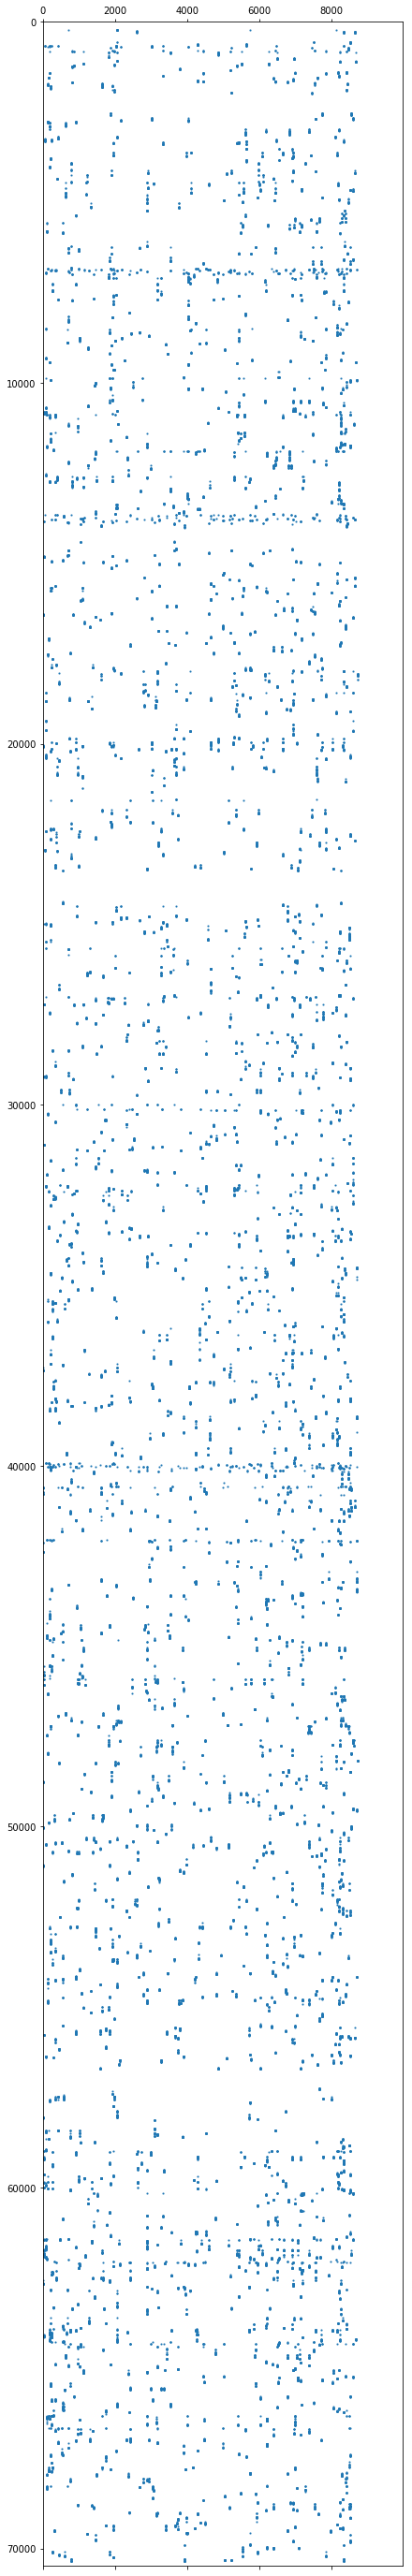

In [107]:
plt.figure( figsize=(30,50) )
plt.spy(codonmat , markersize = 1)

cluster: 0
cluster size: 118
cluster: 1
cluster size: 15
cluster: 2
cluster size: 12


KeyboardInterrupt: 

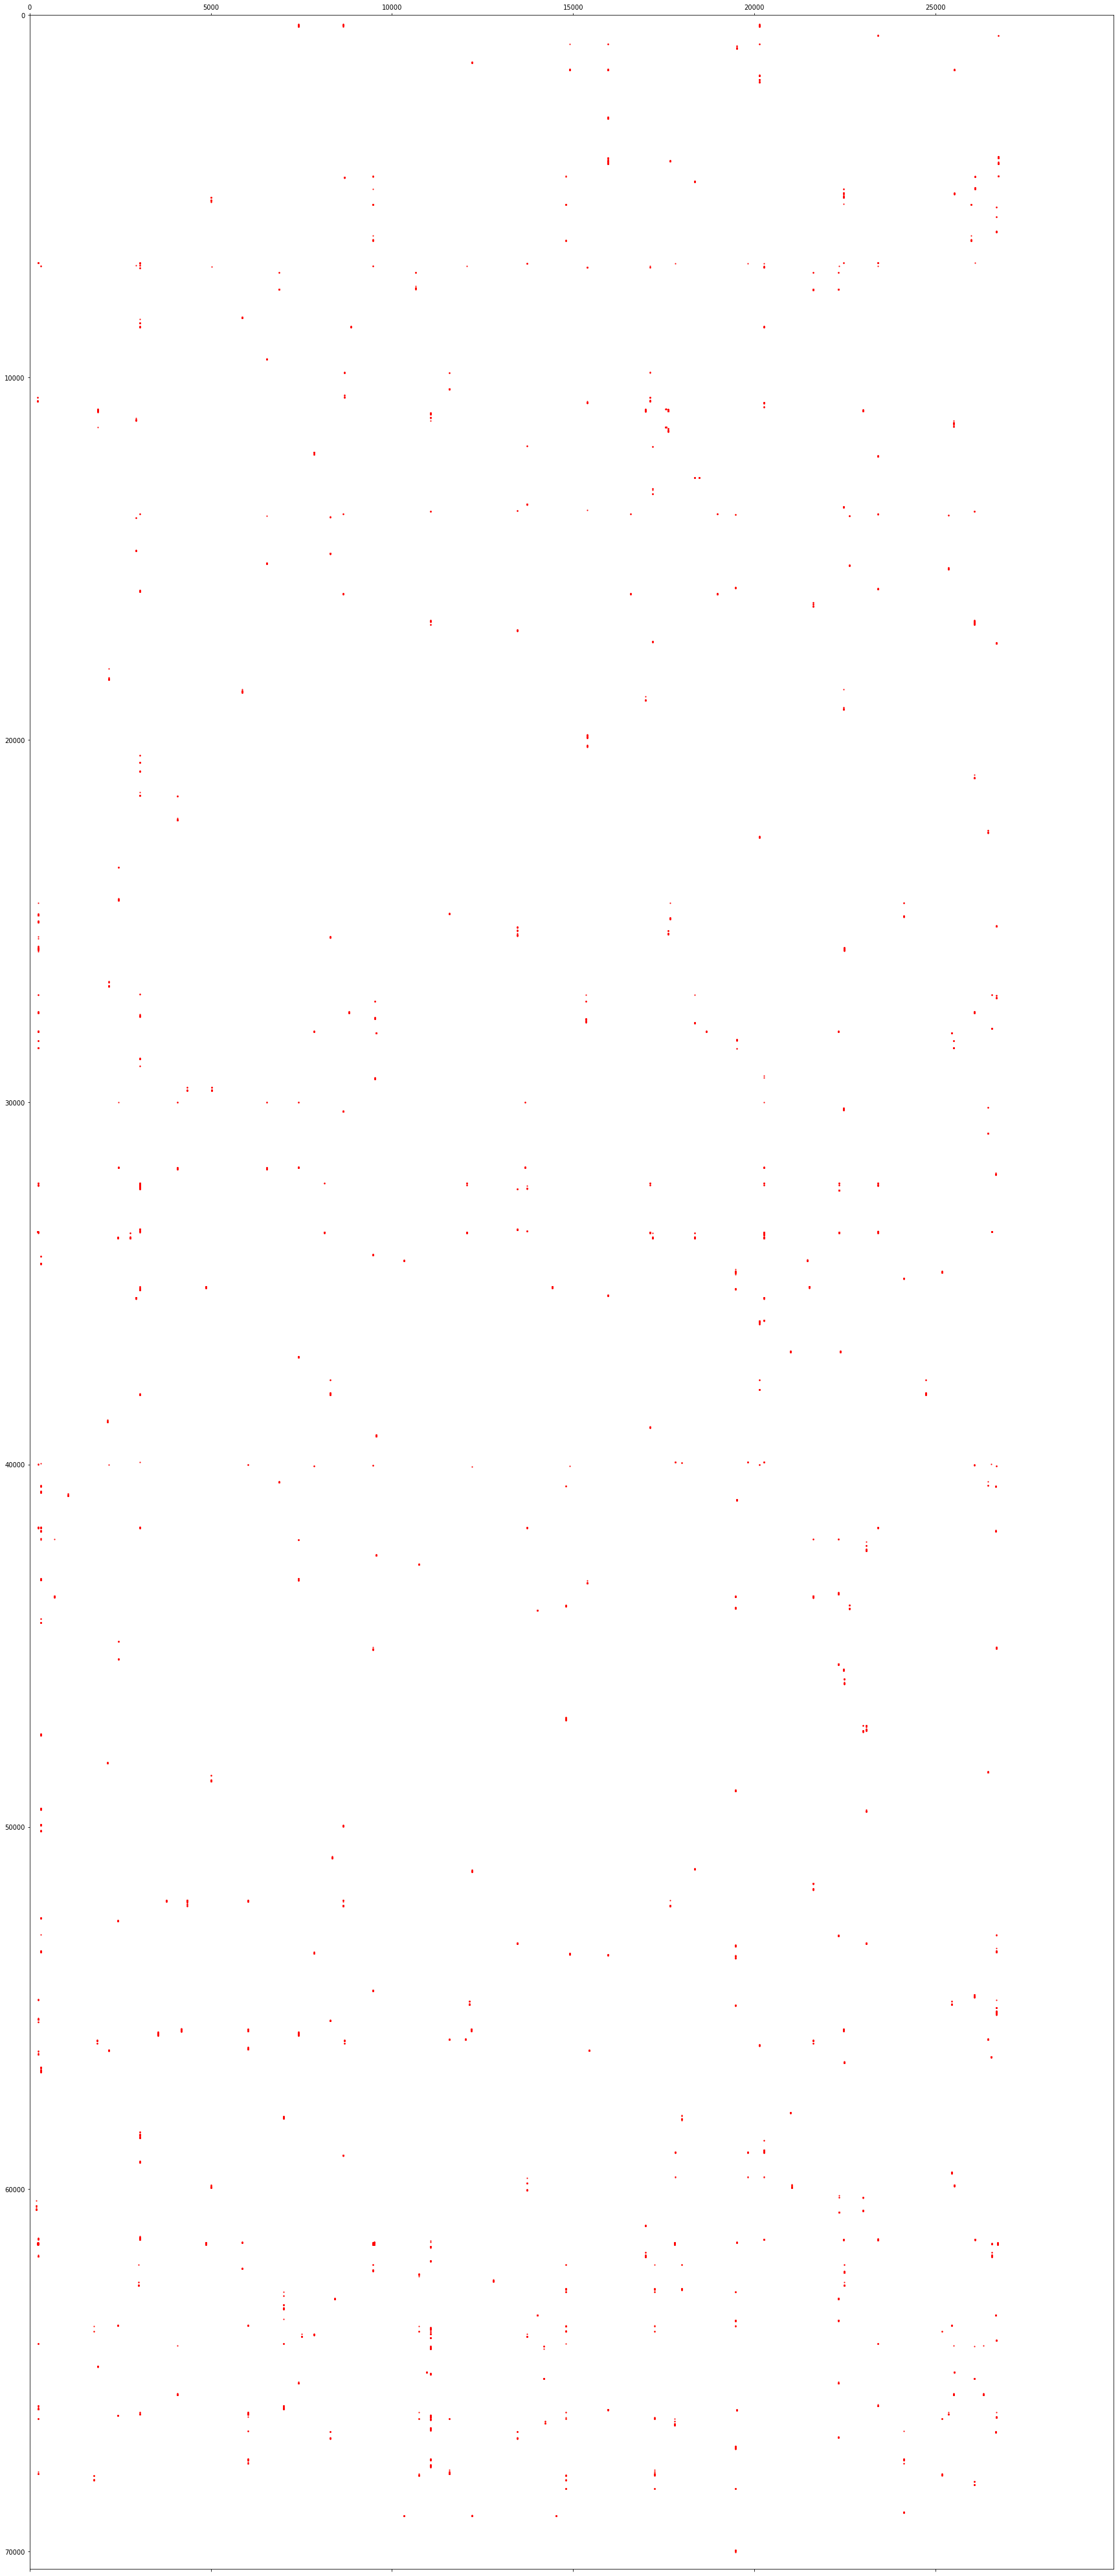

In [ ]:
plt.figure( figsize=(30,200))
plt.spy(codonmat , markersize = 1)

In [ ]:
import pickle
with open( alnfile+'blurmat_codonsr3.pkl' , 'wb') as blurout:
    blurout.write(pickle.dumps(lil_matrix(codonmat) ))



In [ ]:
import pickle

with open( alnfile+'blurmat_codons.pklr3' , 'rb') as blurout:
    codonmat = pickle.loads(blurout.read())

sparsedf = pd.DataFrame.sparse.from_spmatrix(codonmat)

nzx,nzy = codonmat.nonzero()
print(nzx.shape)
print(nzy.shape)
#todo assign clusters to the raw columns
#scatter plot representation of sparse mat
#toggle between
#event mat raw
#blurmat
#codon mat

In [ ]:
datablock = np.vstack([nzx,nzy]).T
print(datablock.shape)

In [110]:
l,c = np.unique(cluster_labelsb, return_counts= True)
print(len(l))
print(c)
print(np.sum(c))



63
[ 136    1    1    1    1    2    1    1    1    1    1    1    1    2
    1    1    2    1    1    1    2    1    2    2    1    2    1    1
    1    1    1    1    5    2    2    1   40   37   26   43   21   50
   15   34   13   21   21   21   14    7    6    1   31   19   15    1
    1   12 9330    1    2    1    1]
9968


In [108]:
#for each cluster output a list of columns in the original alignment

#0 based indexing!


In [86]:
#save each cl
import colour
import numpy as np

red = colour.Color('red')
blue = colour.Color('blue')
crange = [ c.get_hex_l() for c in red.range_to(blue, np.amax(cluster_labelsb)) ]
print(crange)

with open( 'crange.pkl' , 'wb') as crangeout:
    crangeout.write(pickle.dumps(crange))

['#ff0000', '#ff0b00', '#ff1600', '#ff2100', '#ff2b00', '#ff3600', '#ff4100', '#ff4c00', '#ff5700', '#ff6200', '#ff6d00', '#ff7700', '#ff8200', '#ff8d00', '#ff9800', '#ffa300', '#ffae00', '#ffb800', '#ffc300', '#ffce00', '#ffd900', '#ffe400', '#ffef00', '#fffa00', '#faff00', '#efff00', '#e4ff00', '#d9ff00', '#ceff00', '#c3ff00', '#b8ff00', '#aeff00', '#a3ff00', '#98ff00', '#8dff00', '#82ff00', '#77ff00', '#6dff00', '#62ff00', '#57ff00', '#4cff00', '#41ff00', '#36ff00', '#2bff00', '#21ff00', '#16ff00', '#0bff00', '#00ff00', '#00ff0b', '#00ff16', '#00ff21', '#00ff2b', '#00ff36', '#00ff41', '#00ff4c', '#00ff57', '#00ff62', '#00ff6d', '#00ff77', '#00ff82', '#00ff8d', '#00ff98', '#00ffa3', '#00ffae', '#00ffb8', '#00ffc3', '#00ffce', '#00ffd9', '#00ffe4', '#00ffef', '#00fffa', '#00faff', '#00efff', '#00e4ff', '#00d9ff', '#00ceff', '#00c3ff', '#00b8ff', '#00aeff', '#00a3ff', '#0098ff', '#008dff', '#0082ff', '#0077ff', '#006dff', '#0062ff', '#0057ff', '#004cff', '#0041ff', '#0036ff', '#002bff'

In [ ]:

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[],
    y=[0.75, 0.75],
    text=["Unfilled Rectangle", "Filled Rectangle"],
    mode="text",
))

# Set axes properties
fig.update_xaxes(range=[0, 7], showgrid=False)
fig.update_yaxes(range=[0, 3.5])
fig.add_shape(
        # filled Rectangle
            type="rect",
            x0=3,
            y0=10,
            x1=6,
            y1=20,
            line=dict(
                color="RoyalBlue",
                width=2,
            ),
            fillcolor="LightSkyBlue",
        )
fig.update_shapes(dict(xref='x', yref='y'))

fig.show()





In [28]:
import plotly.express as px

nzdf = pd.DataFrame( data = codonmat , columns = ['nzx', 'nzy'] , index = np.arange(nzx.shape[0]) )
nzdf['clusters'] = 0
nzdf['colors'] = '0'
nzdf['size'] = .1


#todo, label the change on each event
for i,l in enumerate(np.unique(cluster_labelsb)):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        labels =  np.where(cluster_labelsb==l)
        nzdf['clusters'][ nzdf['nzy'].isin( labels ) ] =  l
        nzdf['colors'][ nzdf['nzy'].isin(labels) ] =  crange[l]
        nzdf['size'][ nzdf['nzy'].isin(labels) ] =  1

NameError: name 'datablock' is not defined

In [99]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=700, algorithm='randomized', n_iter=20, random_state=0 , tol=0.0)
codon_reduce = svd.fit_transform( codonmat.T )

In [117]:
from sklearn.cluster import MiniBatchKMeans , DBSCAN

apb = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=200, verbose=1, compute_labels=True , random_state= 0   )
#apb = DBSCAN( eps = .2 , metric='jaccard', metric_params=None, algorithm='auto', leaf_size=25, p=None, n_jobs=-1)
cluster_labels_codon = apb.fit_predict(codonmat.T )
cluster_labels_raw = apb.fit_predict(submat_coev.T )
cluster_labels_reduced = apb.fit_predict(codon_reduce )


Init 1/3 with method: k-means++
Inertia for init 1/3: 2748.066238
Init 2/3 with method: k-means++
Inertia for init 2/3: 2894.468013
Init 3/3 with method: k-means++
Inertia for init 3/3: 2750.129511
Minibatch iteration 1/5000: mean batch inertia: 5.157823, ewa inertia: 5.157823 
Minibatch iteration 2/5000: mean batch inertia: 2.627946, ewa inertia: 5.056313 
Minibatch iteration 3/5000: mean batch inertia: 5.256732, ewa inertia: 5.064355 
Minibatch iteration 4/5000: mean batch inertia: 4.217149, ewa inertia: 5.030361 
Minibatch iteration 5/5000: mean batch inertia: 2.954070, ewa inertia: 4.947051 
Minibatch iteration 6/5000: mean batch inertia: 2.597631, ewa inertia: 4.852782 
Minibatch iteration 7/5000: mean batch inertia: 4.060104, ewa inertia: 4.820977 
Minibatch iteration 8/5000: mean batch inertia: 5.870910, ewa inertia: 4.863105 
Minibatch iteration 9/5000: mean batch inertia: 3.853894, ewa inertia: 4.822611 
[MiniBatchKMeans] Reassigning 90 cluster centers.
Minibatch iteration 10/

In [115]:

#blurmat = blurmat.todense()
import copy

plt.figure( figsize=(30,200))
for cluster_labels in []:
    l,c = np.unique(cluster_labelsb, return_counts= True)
    
    print(len(l))
    print(c)
    print(np.sum(c))
    for i,label in enumerate(np.unique(cluster_labelsb_raw)):

        if len(cluster_labelsb_raw[ cluster_labelsb_raw==label ] ) < 200 and len(cluster_labelsb_raw[ cluster_labelsb_raw==label ] ) > 6:
            print('cluster:',label)
            print( 'cluster size:' ,len(cluster_labelsb_raw[ cluster_labelsb_raw==label ] ) )
            mask =  copy.deepcopy(submat_coev)
            mask[:,  cluster_labelsb_raw!=label ] = 0
            plt.spy( mask, markersize = 1 , mfc = crange[i]  , mec = crange[i] )

    plt.show()



51
[ 487   74    1    1   21   72   11   23    4    2   13   15    1    1
    1   12    9    2    1    5    5    7    5    7    4   13    7    1
    4    2    7    1   13   40    2    1    5   27    6  302 8500   29
    1   11   74   33   77    1    1    2   24]
9968


In [114]:
l_reduced,c_reduced = np.unique(cluster_labels_reduced , return_counts= True)
print(len(l_reduced))
print(c_reduced)
print(np.sum(c_reduced))

51
[ 487   74    1    1   21   72   11   23    4    2   13   15    1    1
    1   12    9    2    1    5    5    7    5    7    4   13    7    1
    4    2    7    1   13   40    2    1    5   27    6  302 8500   29
    1   11   74   33   77    1    1    2   24]
9968


In [101]:
clusterdf = { label : [ codon_dict_rev[p] for p in list( np.where(cluster_labelsb == label )[0]  ) if p in codon_dict_rev ] for i,label in enumerate(list(l)) if c[i]< 300 and c[i]> 1 } 

clusterdf = pd.DataFrame.from_dict( clusterdf , orient = 'index' , dtype=pd.Int64Dtype() )

print( clusterdf )
print(clusterdf.index)

clusterdf.to_csv( alnfile + 'clusterpositions_columns.csv')

53
[ 378    1    2    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    2    2    2    1    1    4    2    1    2    2
    1    2    5    6    2    3    2   14   22   22    2   18   49    4
    2    1   10   38   25 9305    1    2    1    1   15]
9968
       0      1      2      3      4      5      6      7      8      9   ...  \
2    3562  24931   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
18  16692  21366   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
19   5053  16944   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
20  11002  25659   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
23  18030  23221  23269  25584   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
24  11074  14391   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
26   4330  17139   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  ...   
27   4474  19116   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>  

In [ ]:
clustervec = np.zeros((100,codon_reduce.shape[1]))



In [88]:
#blurmat = blurmat.todense()
import copy
import random
#shuffle colors
random.shuffle(crange)


cluster: 35
cluster size: 14
cluster: 49
cluster size: 22
cluster: 50
cluster size: 22
cluster: 52
cluster size: 18
cluster: 53
cluster size: 49
cluster: 57
cluster size: 10
cluster: 58
cluster size: 38
cluster: 59
cluster size: 25
cluster: 95
cluster size: 15


No handles with labels found to put in legend.


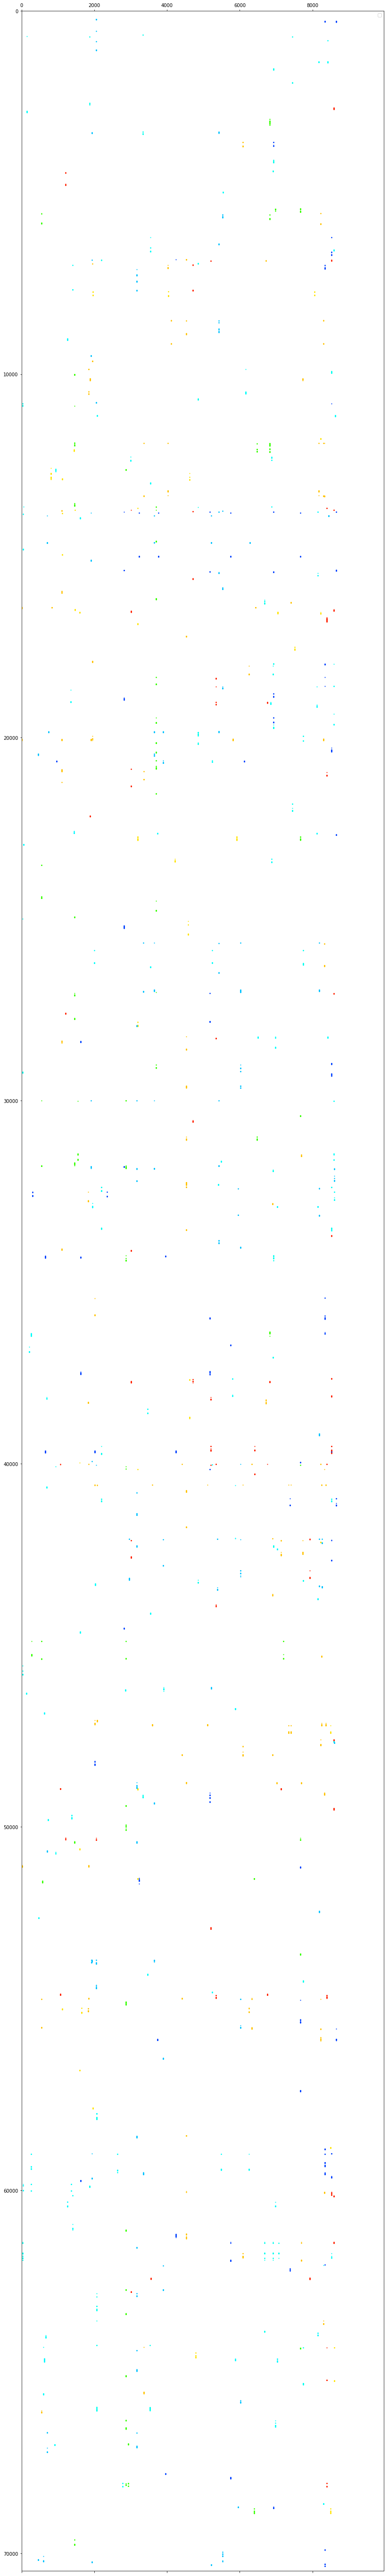

In [92]:
plt.figure( figsize=(30,100))
for i,l in enumerate(np.unique(cluster_labelsb)):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        print('cluster:',l)
        print( 'cluster size:' ,len(cluster_labelsb[ cluster_labelsb==l ] ) )
        mask =  copy.deepcopy(codonmat)
        mask[:,  cluster_labelsb!=l ] = 0
        plt.spy( mask , markersize = 1 , mfc = crange[i]  , mec = crange[i] )
plt.legend( )
        
plt.show()

In [90]:
clusters = {}
import json

count = 0
starts = []
stops =[]
for seq in annotation.prots:
    starts.append( count )
    stops.append( count+len(seq) )
    count += len(seq)

annotation['start'] =  starts
annotation['stop'] = stops
print(annotation)

for l in np.unique(cluster_labelsb):
    if len(cluster_labelsb[ cluster_labelsb==l ] ) < 200 and len(cluster_labelsb[ cluster_labelsb==l ] ) > 6:
        #index of positions
        cluster_postions = np.where( cluster_labelsb==l )
        
        print(cluster_postions)
        
        for i,r in annotation.iterrows():
            for p in list(cluster_postions[0]):
                
                if r.start < p and r.stop > p:
                    
                    if i not in clusters:
                        clusters[i] = {}
                        
                    if l not in clusters[i]:
                        clusters[i][l] = []
                    
                    clusters[i][l].append(p-(r.start-1))

print(clusters)
annotation['clusters']= annotation.index.map( clusters )

#annotation['clusters'] = annotation.clusters.map( lambda x : json.dumps( x ) )
print(annotation)

annotation.to_csv( alnfile + 'testgeno_wclusters.csv')

with open( alnfile + 'annothack.pkl' , 'wb') as annotout:
    annotout.write(pickle.dumps(annotation))


      qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  testgeno  YP_009725298.1  29903   638     806   2719       2   
3   testgeno  YP_009725299.1  29903  1945    2720   8554       2   
17  testgeno  YP_009725300.1  29903   500    8555  10054       2   
21  testgeno  YP_009725301.1  29903   306   10055  10972       2   
25  testgeno  YP_009725302.1  29903   290   10973  11842       2   
41  testgeno  YP_009725303.1  29903    83   11843  12091       2   
32  testgeno  YP_009725304.1  29903   198   12092  12685       2   
37  testgeno  YP_009725305.1  29903   113   12686  13024       2   
34  testgeno  YP_009725306.1  29903   139   13025  13441       2   
12  testgeno  YP_009725307.1  29903   932   13462  16236       1   
15  testgeno  YP_009725308.1  29903   601   16237  18039       1   
16  testgeno  YP_009725309.1  29903   527   18040  19620       1   
19  testgeno  YP_009725310.1  29903   346   19621  20658       1   
23  testgeno  YP_009725311.1  29903   298   2065